# EfficientSAM使用示例demo

In [45]:
import cv2
import re
import torch
import zipfile
import os.path as osp
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display

In [54]:
from IPython.display import HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

设置展示`蒙版`，`标点`，`标注框`函数

In [47]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [49]:
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")

Build the EfficientSAM-Ti model.  
构建EfficientSAM-Ti和EfficientSAM-S 

In [62]:
import sys
sys.path.append("..")
from efficient_sam import SamPredictor
from efficient_sam import efficient_sam_model_registry
    
device = "cuda"
model_type = 'vit_s'
model = efficient_sam_model_registry[model_type]()

ModuleNotFoundError: No module named 'predictor'

Load an image "figs/examples/dogs.jpg"  
载入示例图片

In [41]:
example_img_path = 'figs/examples'
output_img_path = 'figs/outputs'

img_name = 'remu.png'

In [42]:
sample_image_np = cv2.imread(osp.join(example_img_path, img_name))
sample_image_np = cv2.cvtColor(sample_image_np, cv2.COLOR_BGR2RGB)
sample_image_tensor = transforms.ToTensor()(sample_image_np)

Process the image to produce an image embedding by calling `SamPredictor.set_image`.   
`SamPredictor` remembers this embedding and will use it for subsequent mask prediction.  
通过调用SamPredictor.set_image处理图像以生成图像嵌入。SamPredictor会记住这个嵌入，并在后续的掩码预测中使用它。

Feed a few (x,y) points in the mask as input.  
设置鼠标点击位置(x, y)为输入

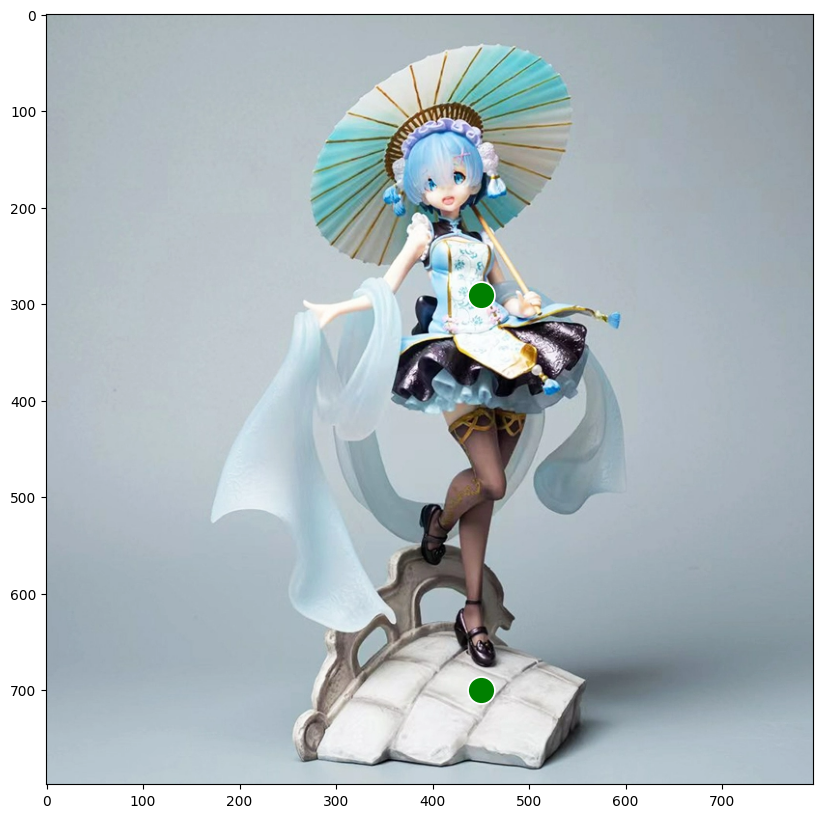

In [43]:
input_points = torch.tensor([[[[450, 290], [450, 700]]]])
input_labels = torch.tensor([[[1, 1]]])

plt.figure(figsize=(10,10))
plt.imshow(sample_image_np)
show_points(input_points.numpy(), input_labels.numpy(), plt.gca())
plt.axis('on')
plt.show()

Run inference for both EfficientSAM-Ti and EfficientSAM-S models.  
对EfficientSAM-Ti和EfficientSAM-S模型进行推理

掩码已按其预测的IoU进行排序。
- 第一维是批处理大小（我们只有一张图像，所以是1）。
- 第二维是我们要生成的掩码数量（在这种情况下，只有1个）。
- 第三维是模型输出的候选掩码数量。
对于这个演示，我们使用第一个掩码。

使用efficientsam_s进行推理 


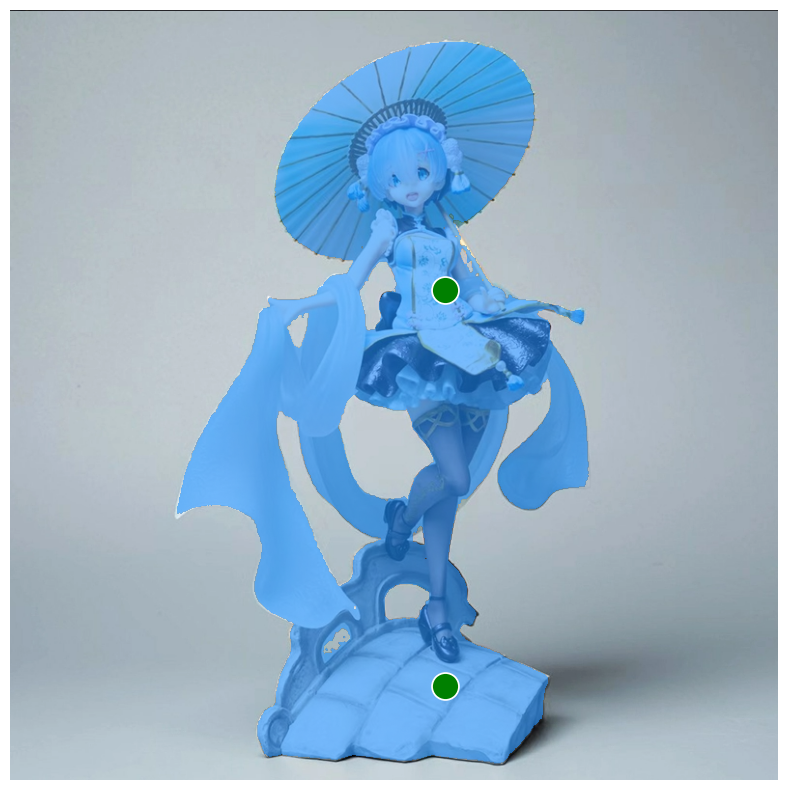

NameError: name 'model_name' is not defined

In [44]:
print(f'使用{model_type}进行推理 ')
predicted_logits, predicted_iou = model(
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
predicted_logits = torch.take_along_dim(
    predicted_logits, sorted_ids[..., None, None], dim=2
)
mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(sample_image_np)
show_mask(mask, plt.gca())
show_points(input_points.numpy(), input_labels.numpy(), plt.gca())
plt.axis('off')
plt.show()

# 保存为带有透明度的四通道BGRA格式：
masked_image_np = sample_image_np.copy().astype(np.uint8)
masked_image_np = cv2.cvtColor(masked_image_np, cv2.COLOR_RGB2BGRA)  # 转换为带有透明度的图像
mask = np.where(mask, 255, 0).astype(np.uint8)
masked_image_np[:,:,3] = mask  # 设置透明度

# 保存结果为PNG格式
img_name_no_ext = re.sub(r'\.[^.]*$', '', img_name)
save_path = osp.join(output_img_path, f"{img_name_no_ext}_{model_type}_mask_BGRA.png")
cv2.imwrite(save_path, masked_image_np)
# masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]
    